In [12]:
# load dataset
import pandas as pd 
import pickle
df = pickle.load(open('politician_posts_party.pkl','rb'))
print(len(df))
df = df[df.message.apply(type)==str]
df.shape

506047


(472046, 12)

In [14]:
base = '/home/snorre/Dropbox/Forskning/bigdata/data_inspections/'
meta_path = base+'simulation_results/metrics/'
meta_path2 = base+'simulation_results/distributions/'
from os import listdir
result_path = '/mnt/b0c8e396-e5ba-4614-be6f-146c4c861ab3/data/topic_model_simulation/models/'
model_runs = set(['_'.join(i.split('_')[0:3]) for i in listdir(result_path)])
model_runs = sorted(model_runs,key=lambda x: int(x.split('_')[-1]))
print(len(model_runs))
#pol_df = pd.read_csv(base+'data/topic_modelling_dataset.csv').drop('bow',axis=1)
import pickle

pol_df,noise_df, Index = pickle.load(open(base+'topic_simulation_dependencies.pkl','rb'))
# Define where the noise begins.
noise_start_w = 30000
noise_start_d = len(pol_df)
list(enumerate(Index))[noise_start_w-2:noise_start_w+2],noise_start_w,noise_start_d

8559


([(29998, 'læhegn'),
  (29999, 'heder'),
  (30000, 'americans'),
  (30001, 'makeamericagreatagain')],
 30000,
 46209)

In [15]:
import json
class2num = dict(pol_df[['topic','topic_class']].values)
class2num = sorted(class2num,key=lambda x: class2num[x])
dictionary = [(topic,set(values)) for topic,values in json.load(open('dictionary_topics.js','r')).items()]
from nltk.stem.snowball import DanishStemmer
import nltk
stemmer = DanishStemmer()

w2lex = {}

for topic,vals in dictionary:
    for val in vals:
        if val in w2lex:
            w2lex[val].append(topic)
            #print(val,topic,w2lex[val])
        w2lex[val] = [topic]

lex2idx = {topic:set() for topic in class2num}
#idx2lex = {idx:lex for lex,indices in lex2idx.items() for idx in indices }
in_lex = set()
for num,w in enumerate(Index):
    if w in w2lex:
        topics = w2lex[w]
        for topic in topics:
            lex2idx[topic].add(num)
    w_stem = stemmer.stem(w)
    if w_stem in w2lex:
        topics = w2lex[w_stem]
        for topic in topics:
            lex2idx[topic].add(num)

idx2lex = {}
for dicname,values in lex2idx.items():
    for val in values:
        idx2lex[val] = dicname

sum([len(s) for s in lex2idx.values()]),len(w2lex),len(idx2lex)

(1338, 692, 1338)

In [81]:
topwords= pickle.load(open('Topword_Occurence.pkl','rb'))
def load_dataframe(filename,names = ['word','idx','include','top_occurence']):
    try:
        df = pd.read_csv(filename,names = names,encoding='latin1')
    except:
        df = pd.read_csv(filename,names = names,encoding='utf-8')
    return df
suspect_df = pd.read_csv('lexicon_extension_suspects.csv')
dones = []
for name,groupdf in suspect_df.groupby('best_match'):
    filename = 'lexicon_extension_%s.csv'%name
    done_df = load_dataframe(filename)
    dones.append(done_df)
done_df = pd.concat(dones)
len(done_df)
include = set(done_df[done_df.include==3].idx)
#dict(suspect_df[suspect_df.idx.isin(include)][['idx','best_match_dk']].values)
idx2lex.update(dict(suspect_df[suspect_df.idx.isin(include)][['idx','best_match_dk']].values))


In [82]:
lex2w = {lex:set() for lex in idx2lex.values()}
for idx,lex in idx2lex.items():
    lex2w[lex].add(Index[idx])

In [24]:
import nltk
def get_topic(text):
    
    words = set([w.lower() for w in nltk.word_tokenize(text)])
    d2top = np.zeros(len(lex2w))
    for num,top in enumerate(class2num):
        
        s = lex2w[top]
        d2top[num] = len(s&words)
    return d2top
import numpy as np
    
t_assignments = np.array([get_topic(text) for text in df.message])

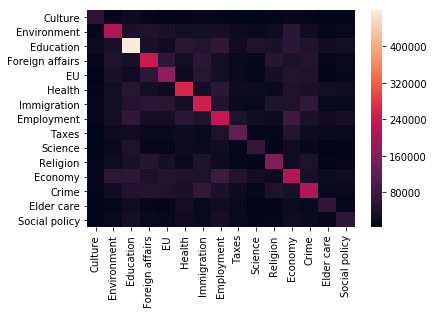

In [75]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
columns = [get_dic_name(i) for i in range(15)]
sns.heatmap(pd.DataFrame(t_assignments.T.dot(t_assignments),columns=columns,index=columns))

In [99]:
topic_df = pd.DataFrame(t_assignments,columns=[get_dic_name(i) for i in range(15)])

In [114]:
df_t = pd.concat([df.reset_index(drop=True),topic_df.reset_index(drop=True)],axis=1)

In [240]:
df_t['No category'] = t_assignments.sum(axis=1)==0

In [162]:
certainty = 10
15*15*10 * certainty

22500

In [138]:
cat2count = (t_assignments>0).sum(axis=0)

In [ ]:
budget = 10000
split_col = 'party'
n_split = df_t[split_col].nunique()
split_k = budget/n_split


In [135]:
# sample p2t
samples = []
for val in set(df_t[split_col]):
    temp = df_t[df_t[split_col]==val]
    for i in range(15):
        ## assume 
        sub_budget = 
        sub = temp[temp[get_dic_name(i)]>0]
    t_sample = sub.groupby('party').apply(lambda x: x.sample(min([len(x),100]))).reset_index(drop=True)
    t_sample['topic_class'] = i
    
    samples.append(t_sample)

In [279]:
len(class_cols)*10,len(t_sample)

(150, 1500)

In [286]:
samples = []
true_percentage = 0.5
overlap_percentage = 0.1

class_cols = [get_dic_name(i) for i in range(15)]
n_pr_class = 10
n_samples = len(class_cols) * n_pr_class


def make_sample(groupdf):
    sample = groupdf.sample(n_samples,replace=True).reset_index()
    sample['presented_class'] = class_cols*n_pr_class
    return sample
## non category
t_sample = df_t[df_t['No category']==1].groupby('party').apply(make_sample).reset_index(drop=True)
t_sample['topic_class'] = 'No category'



#t_sample.loc[~t_sample.true_class,'presented_class'] = [random.choice(class_cols) for _ in range(sum(~t_sample.true_class))]
t_sample['inter_coder'] = [np.random.uniform()<=overlap_percentage for _ in range(len(t_sample))]
samples.append(t_sample)
for i in class_cols:
    sub = df_t[df_t[i]>0]
    df.reset_index()
    t_sample = sub.groupby('party').apply(make_sample).reset_index(drop=True)#col_fill='doc_id')
    t_sample['topic_class'] = i
    #id2true = {doc_id:np.random.uniform()<=true_percentage for doc_id in t_sample['index']}
    
    
    #t_sample['presented_topic'] = range(15) 
    t_sample['inter_coder'] = [np.random.uniform()<=overlap_percentage for _ in range(len(t_sample))]
    samples.append(t_sample)
p_sample = pd.concat(samples)
p_sample.shape

(24000, 32)

In [305]:

#p_sample.groupby(['inter_coder','presented_class']).size()[False]

In [307]:
24000 / 100

240.0

In [311]:
240*130

31200

In [312]:
## sentence level to make it cheaper. And find the best number of category choices pr sentence.


In [ ]:
## how can we make it cheaper?

## Assume independence of parties and subcategories for recall. 

## Sentence level.

## Increase the number of Categories pr sentence, violating some assumption.

## If not in a multiclass setting then they will rule each other out.



In [319]:
p_sample['index'].value_counts().values[p_sample['index'].value_counts()>1].sum() / len(p_sample)

0.18945833333333334

In [290]:
#p_sample.groupby(['topic_class','presented_class']).size().unstack()

In [295]:
10*10*15*15 + 10*150

24000

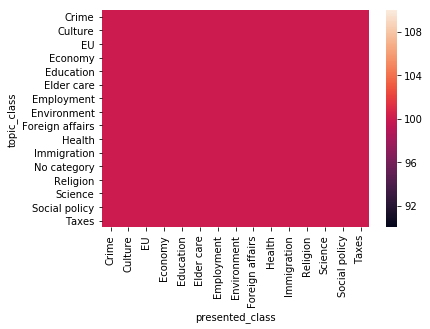

In [292]:
sns.heatmap(p_sample.groupby(['topic_class','presented_class']).size().unstack())

In [234]:
df.sample(10).sample(20)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
df.sample

In [199]:
# determine which class to present.
import random
n = 100000
Counter([random.random()>=0.5 for i in range(n)])[True]/n

0.499863

In [211]:
n = 100000
print(np.mean([abs(0.5-Counter([np.random.uniform()>=0.5 for i in range(n)])[True]/n) for _ in range(10)]))
print(np.mean([abs(0.5-Counter([random.random()>=0.5 for i in range(n)])[True]/n) for _ in range(10)]))



0.000984999999999997
0.0016280000000000183


In [86]:
#Counter(t_assignments.flatten())

In [39]:
def re_count(regex_pattern, thestring):
    return len(regex_pattern.findall(thestring))

def re_count2(regex_pattern, thestring):
    total = 0
    start = 0

    while True:
        mo = regex_pattern.search(thestring, start)
        if mo is None: return total
        total += 1
        start = 1 + mo.start()

In [40]:
lex_regexes = {}
for lex,patterns in lex2w.items():
    ## add back and forward check (whitespace,- or first), (white space, - ? or end)
    #patterns = [''.join([back_look,pattern,end_look]) for pattern in patterns]
    pattern = re.compile('|'.join(patterns))
    lex_regexes[lex] = pattern
    

In [43]:
sample_df = df.sample(2000).copy()

In [57]:
def match_topics(df):
    for lex in class2num:
        pattern = lex_regexes[lex]
        
        df[lex] = df.message.apply(lambda x: re_count2(pattern,x))
    return df
def simple_count(patterns,text):
    return sum([text.count(pattern) for pattern in patterns])
def match_topics2(df):
    for lex in class2num:
        
        ws = lex2w[lex]
        df[lex] = df.message.apply(lambda x: simple_count(patterns,x) )
    return df

In [59]:
#match_topics2(sample_df)

In [60]:
%timeit match_topics(sample_df)
%timeit match_topics2(sample_df)

1 loop, best of 3: 2.26 s per loop
1 loop, best of 3: 586 ms per loop


In [41]:
%timeit re_count(pattern,sample)
%timeit re_count2(pattern,sample)
%timeit sum([sample.count(pattern) for pattern in patterns])

100 loops, best of 3: 2.31 ms per loop
100 loops, best of 3: 2.15 ms per loop
1000 loops, best of 3: 1.02 ms per loop


yo


In [37]:
%timeit re_count(regex_pattern,sample)
%timeit re_count2(regex_pattern,sample)
%timeit sum([sample.count(pattern) for pattern in patterns])

1000 loops, best of 3: 250 µs per loop
1000 loops, best of 3: 248 µs per loop
10000 loops, best of 3: 57.6 µs per loop


In [27]:
sample = ' '.join(df.sample(100).message)

In [32]:
sample.count('politik'),sample.count('dkpol')

(18, 5)

In [30]:
import re
countoverlappingdistinct('politik',sample)

18

In [33]:
%timeit countoverlappingdistinct('politik|dkpol',sample)
%timeit sample.count('politik'),sample.count('dkpol')

The slowest run took 5.05 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 250 µs per loop
10000 loops, best of 3: 33.2 µs per loop


## Simulate certainty

In [ ]:
n_draws = np.arange(10,1000,10)
percentages = np.linspace(0.01,0.90,100)
iters = 10000
p2errors = []
from tqdm import tqdm_notebook as tqdm
for perc in tqdm(percentages):
    errors = []
    for n in n_draws:
        temp = []
        for i in range(iters):
            draws = [np.random.uniform()<=perc for _ in range(n)]
            estimate = np.mean(draws)
            error = abs(estimate-perc)
            temp.append(error)
        errors.append((np.quantile(temp,0.05),np.mean(temp),np.quantile(temp,0.95)))#np.quantile(temp,0.95)
    p2errors.append(errors)


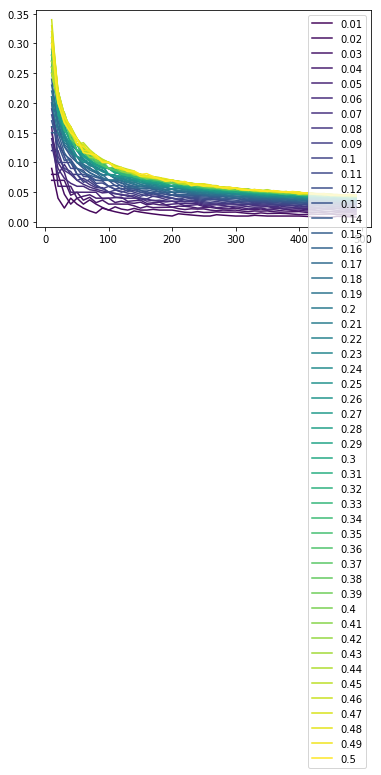

In [359]:
for num,errors in enumerate(p2errors):
    l,y,u = zip(*errors)
    plt.plot(n_draws,u,label=round(percentages[num],3),color=plt.cm.viridis(percentages[num]/max(percentages)))
plt.legend()

In [ ]:
# In a single class setting.  
    ## Fist estimate precision. 
    ## Weigh the errors to 

In [352]:
np.quantile(temp,0.95),np.mean(temp)

(0.05789473684210528, 0.023273684210526314)

[0.117,
 0.09499999999999999,
 0.06699999999999999,
 0.05474999999999999,
 0.0552,
 0.05249999999999999,
 0.0477142857142857,
 0.0415,
 0.04133333333333332,
 0.03900000000000001,
 0.04172727272727272,
 0.033666666666666664,
 0.03307692307692306,
 0.03328571428571428,
 0.03,
 0.029249999999999995,
 0.03064705882352941,
 0.026722222222222213,
 0.03357894736842106]

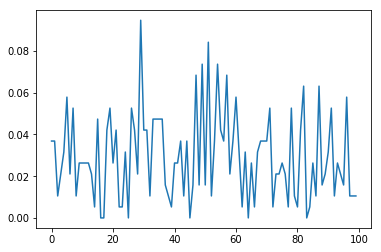

In [334]:
plt.plot(np.array(temp))

In [74]:
get_dic_name(1)

'Environment'

In [72]:
## Classify the posts.
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
class2english = {'kunst _musik_museum_kulturpol': 'Culture', ' klima_ miljø _ naturen ': 'Environment',
                 'undervis_folkeskole_ungdomsuddan': 'Education', 'udenrig_ forsvaret _militær': 'Foreign affairs',
                 ' EU _ eu': 'EU', ' sundhed': 'Health',
                 'indvandr_flygt_udlænding': 'Immigration', ' beskæftig': 'Employment', 'skat': 'Taxes', 
                 'forskning_ universitet_videregående udd': 'Science',
                 ' religi_ værdipol': 'Religion', ' økonom_ vækst': 'Economy', 
                 'kriminal_kriminel': 'Crime', 'hjemmehjælp_ ældre _ pension_ plejehjem': 'Elder care',
                 'fattig_socialt udsat_socialminis_svageste': 'Social policy'}
def get_dic_name(num):
    return class2english[class2num[int(num)]]
import pickle,json,networkx as nx